<a href="https://colab.research.google.com/github/LongNguyen1984/TimeSeriesWithPython/blob/main/TwoVariablePPGGlucoseModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
**This use a 2-varible model to predict gluocse**
Y = $\alpha_1$*$X_1$ + $\alpha_2$*$X_2$ + $\beta$

Where: 
  * $X_1$: DC level of PPG
  * $X_2$: Pulse Transition Time (PTT) of PPG


##Import and Load PPG data

The PPG data has 4 channels with a sampling rate 70
 

In [613]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks

import pandas as pd
#ppg  = pd.read_csv('drive/MyDrive/Dataset/long2aprilgLab1.csv', header=0)
#ppg  = pd.read_csv('drive/MyDrive/Dataset/long1aprilgLab1.csv', header=0)
ppg  = pd.read_csv('drive/MyDrive/Dataset/long31marchLab1.csv', header=0)
# print out 20 first row of PPG
ppg.head(20)

,850nm,640nm,940nm,580nm,Channel 5,Channel 6,Channel 7,Channel 8
0,50378,-795181,165305.0,-869928.0,0.0,0.0,0.0,0.0
1,50141,-795374,165205.0,-870020.0,0.0,0.0,0.0,0.0
2,50084,-795528,165085.0,-870498.0,0.0,0.0,0.0,0.0
3,50617,-794561,165669.0,-869954.0,0.0,0.0,0.0,0.0
4,50745,-794352,165940.0,-869399.0,0.0,0.0,0.0,0.0
5,51308,-793850,166452.0,-868499.0,0.0,0.0,0.0,0.0
6,51614,-793046,166845.0,-867640.0,0.0,0.0,0.0,0.0
7,51581,-793632,166708.0,-867629.0,0.0,0.0,0.0,0.0
8,51411,-793315,166994.0,-868015.0,0.0,0.0,0.0,0.0
9,51607,-792544,167030.0,-867939.0,0.0,0.0,0.0,0.0


### Read PPG at 525nm


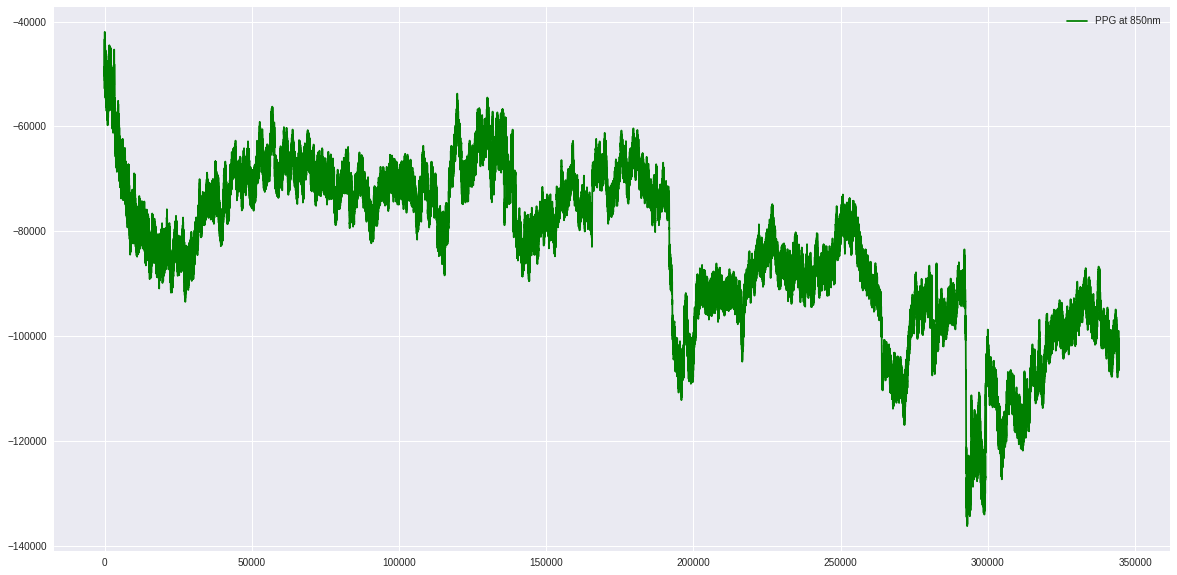

In [714]:
plt.style.use('seaborn')
#name = '580nm'
#name = '940nm'
#name = '640nm'
name = '850nm'
ppg525 = -ppg[name][0:]
plt.figure(1, figsize=(20,10))
# colors for the line plot
colors = ['green', 'red', 'purple']

plt.plot(ppg525, "g-", label='PPG at ' + str(name))
plt.legend()

####Check Outliner

In [715]:
low = .0005
high = .9995
quant_df = ppg525.quantile([low, high])
print(quant_df)

0.0005   -132905.000
0.9995    -46887.585
Name: 850nm, dtype: float64


###Remove Outliner

In [716]:
index = (ppg525.values < quant_df[high])
fal_idx = ~ index
ppg525[fal_idx] = np.nan

In [681]:
#interpolation
ppg525.interpolate(method='linear', limit_direction='forward', axis=0, inplace=True)

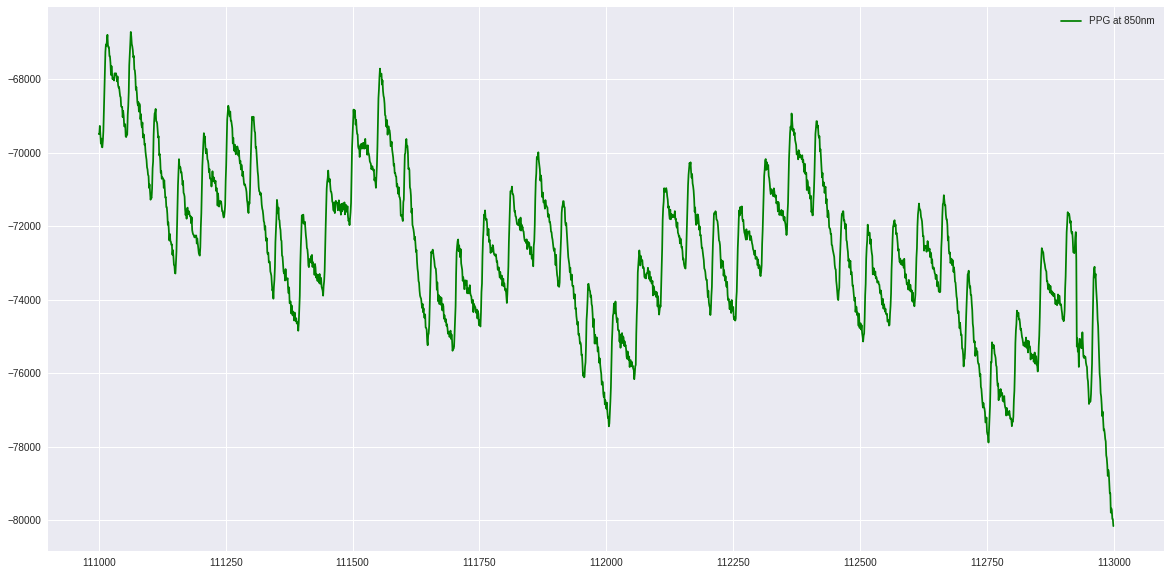

In [721]:
plt.figure(1, figsize=(20,10))
plt.plot(ppg525[111000:113000], "g-", label='PPG at '+str(name))
plt.legend()

###Filtering with S-Golay filter

In [722]:
from scipy.signal import savgol_filter
filter_PPG = savgol_filter(ppg525, 25, 7, mode='nearest')

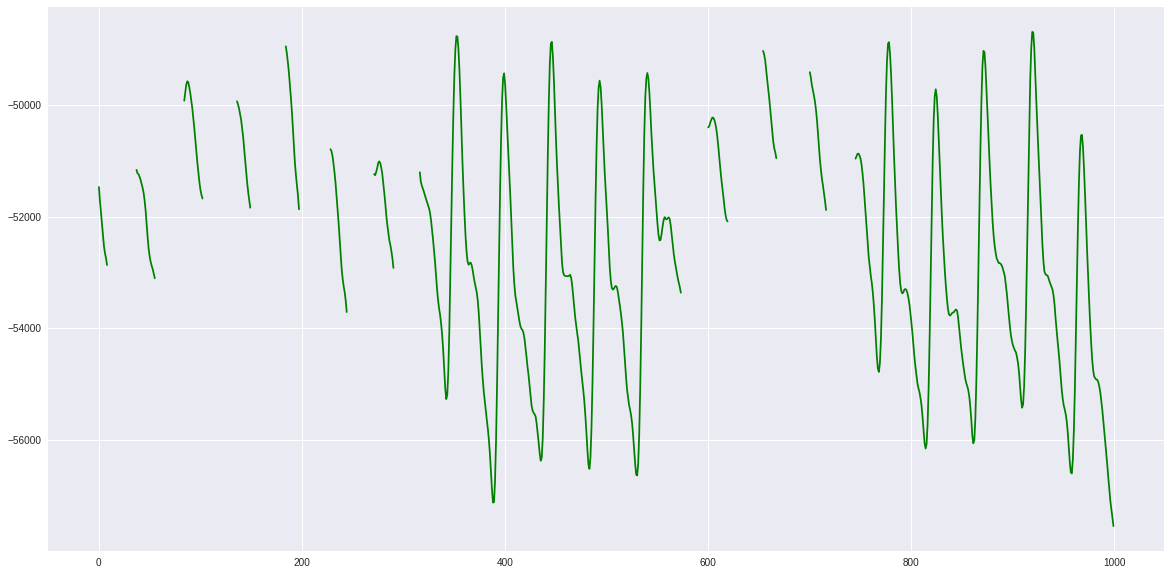

In [723]:
plt.figure(1, figsize=(20,10))
plt.plot(filter_PPG[1500:2500], "g-", label='PPG at 525nm')

# Detect peak

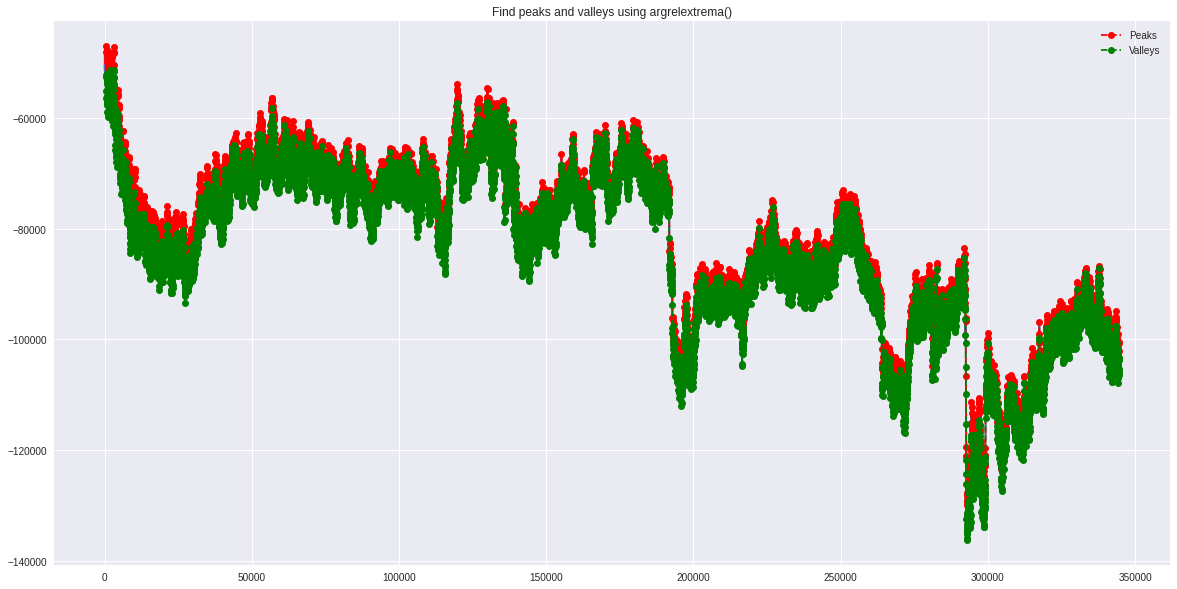

In [724]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

L1, L2 = 0, len(filter_PPG)
# find peak max
peak_idxs = signal.argrelextrema(filter_PPG, np.greater,order=18)
peak_idxs = peak_idxs[0]
peak_idxs = [i  for i in peak_idxs if (i >=L1 and i <=L2)]

#find peak min
valley_idxs = signal.argrelextrema(filter_PPG, np.less,order=1)
valley_idxs = valley_idxs[0]
valley_idxs = [i  for i in valley_idxs if (i >=L1 and i <=L2)]
#plot main graph
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(filter_PPG[L1:L2])
# plot peaks
peak_x = [i - L1 for i in peak_idxs]
peak_y =  filter_PPG[peak_idxs]
ax.plot(peak_x, peak_y, marker='o', linestyle='dashed', color='r', label='Peaks')
# plot valleys
valley_x = [i - L1 for i in valley_idxs]
valley_y =  filter_PPG[valley_idxs]
ax.plot(valley_x, valley_y, marker='o', linestyle='dashed', color='g', label='Valleys')

# Save graph to file.
plt.title('Find peaks and valleys using argrelextrema()')
plt.legend(loc='best')
#plt.savefig('argrelextrema.png')

In [686]:
len(peak_y), len(valley_y)

(7220, 15305)

### Reselecting valleys


In [725]:
def select_valley(peaks,valleys,sel='backward'):
  assert len(peaks) < len(valleys), "Need the valley set bigger than the peak set."
  assert len(valleys) > 2, "Need the valley set at least 2 element."
  assert len(peaks) > 1, "Need the valley set at least 1 element."
  val = []
   
  if sel =='backward':
    idx = 0 #position of valley smaller than peaks
    for p in peaks:
      for v,v_next in zip(valleys[idx:-1], valleys[idx+1:]):
        if v < p and v_next > p:
          val.append(v)
          idx = valleys.index(v)
          break
  elif sel == 'forward':
    idx = 1 #position of valley smaller than peaks
    for p in peaks:
      for v,v_next in zip(valleys[idx:], valleys[idx-1:-1]):
        if v > p and v_next < p:
          val.append(v)
          idx = valleys.index(v)
          break
      #elif ((v < p) and ((v - val[-1])> np.mean(np.diff(val)*0.9))):
      #  val.append(v)
  #if (valleys[-1] - val[-1])>np.mean(np.diff(val))*0.8:
  #  val.append(valleys[-1])
  return val

## Select vally close to peak set
val = select_valley(peak_idxs,valley_idxs, sel='backward') #'forward'

In [726]:
len(val), len(peak_idxs), len(valley_idxs)

(7155, 7156, 12282)

#### Draw in region (L1, L2)

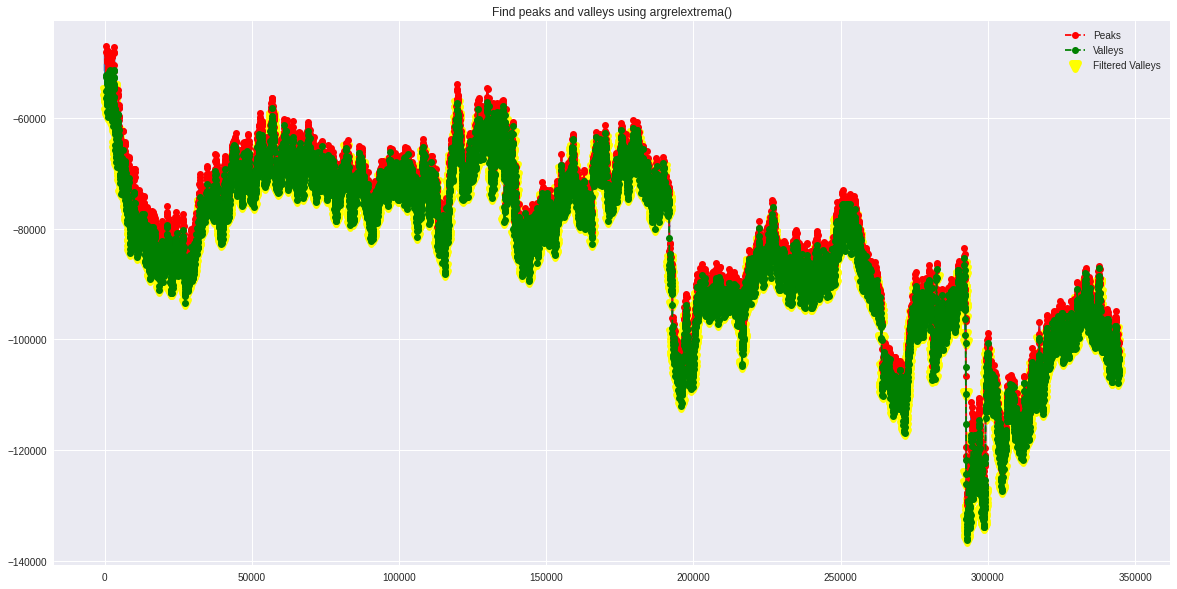

In [727]:
#L1, L2 = 111000, 113000#len(filter_PPG)
L1, L2 = 0, len(filter_PPG)
#plot main graph
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(filter_PPG[L1:L2])
# plot peaks
peak_x = [i - L1 for i in peak_idxs if i>=L1 and i < L2]
peak_y =  filter_PPG[np.array(peak_x)+L1]
ax.plot(peak_x, peak_y, marker='o', linestyle='dashed', color='r', label='Peaks')
# plot valleys
valley_x = [i - L1 for i in valley_idxs if i>=L1 and i < L2]
valley_y =  filter_PPG[np.array(valley_x)+L1 ]
ax.plot(valley_x, valley_y, marker='o', linestyle='dashed', color='g', label='Valleys')
# plot filterd valleys
valley_filtx = [i - L1 for i in val if i>=L1 and i < L2]
valley_filty =  filter_PPG[np.array(valley_filtx)+L1]
ax.scatter(valley_filtx, valley_filty, marker='v', linewidth=6, color='yellow', label='Filtered Valleys')
# Save graph to file.
plt.title('Find peaks and valleys using argrelextrema()')
plt.legend(loc='best')
#plt.savefig('argrelextrema.png')

### Draw difference Peak-Valley

In [728]:
peak_y[0], valley_y[0],len(peak_y), len(valley_y)

(-46931.12756128522, -55087.873028494934, 7156, 12282)

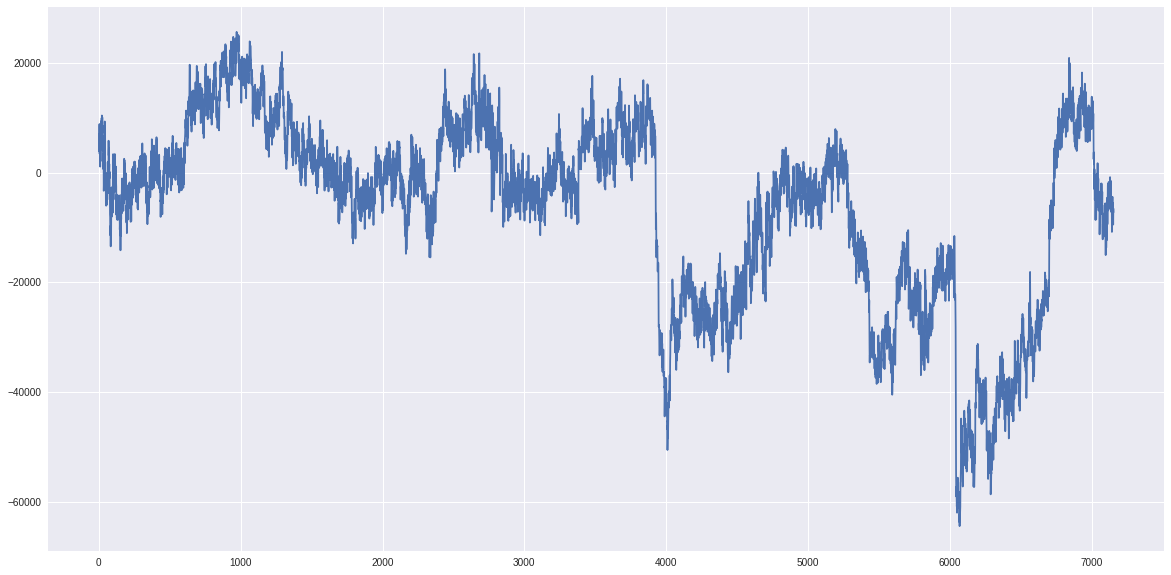

In [729]:
L = min(len(peak_y), len(valley_y))

z = np.array(peak_y[1:L]) - np.array(valley_y[0:L-1])

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(z)




In [692]:
dz = np.gradient(z)
df_z = pd.DataFrame(dz)
df_z.index = [x for x in range(0, len(df_z.values))]
#df_z == np.nan

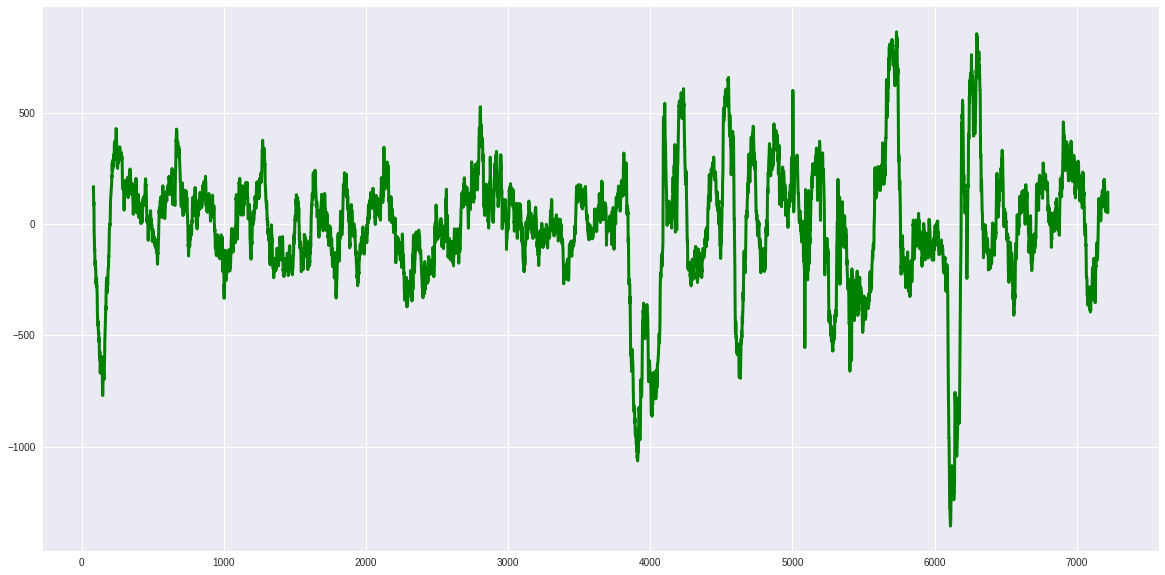

In [693]:
#plt.figure(1, figsize=(10,10))
# colors for the line plot
#colors = ['green', 'red', 'purple']

dzMA = df_z.rolling(84  ).mean()### 'blackman','bohman win_type='blackman'

### create a combine dataframe
#df = pd.DataFrame(dzMA)
#df['avg'] = ppgMVA
#plt.plot(ppg525, "g-", label='PPG at 525nm')
#plt.plot(ppgMVA, "r-", label='Moving Average of PPG at 525nm')
plt.figure(1, figsize=(20,10))
plt.plot(dzMA, "g-", label='PPG at 525nm',linewidth=3)
#dzMA.plot(color=colors, linewidth=3, figsize=(20,10))

# modify ticks size
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
#plt.legend(labels =['PPG at 525nm', 'Moving Average PPG' ], fontsize=14)

# title and labels
#plt.title('PPGs at Guan point in 2 hours', fontsize=20)
#plt.xlabel('Sample', fontsize=16)
#plt.ylabel('Amplitude', fontsize=16)

In [694]:
dzMA.isna().sum()

0    83
dtype: int64

In [695]:
len(z), L

(7219, 7220)

### Extract PPG from Baseline

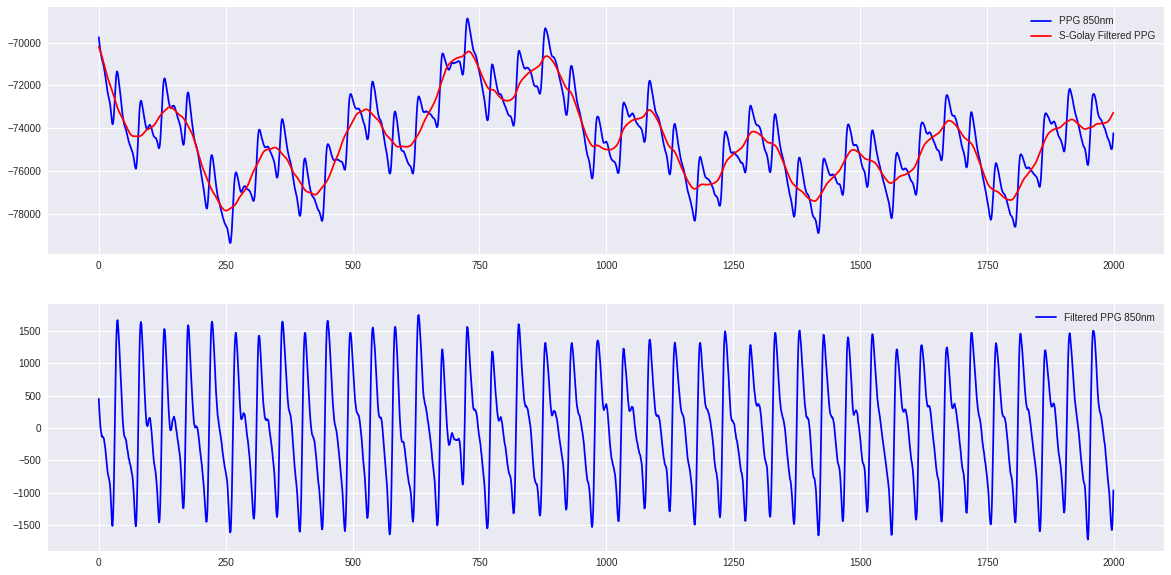

In [730]:
from scipy.signal import savgol_filter

filter_PPG1 = savgol_filter(filter_PPG, window_length = 211, polyorder =5)

bwrPPG1 = filter_PPG - filter_PPG1

plt.subplots(2, 1, figsize=(20,10))
L1, L2 = 83000, 85000
#L1, L2 = 0, len(bwrPPG1)
#plt.subplot(3, 1, 1)
plt.subplot(2, 1, 1)
plt.plot(filter_PPG[L1:L2], "b-", label="PPG " + str(name))
plt.plot(filter_PPG1[L1:L2], "r-", label="S-Golay Filtered PPG")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(bwrPPG1[L1:L2], "b-", label="Filtered PPG " + str(name))
plt.legend()

### Detect peaks filter signal

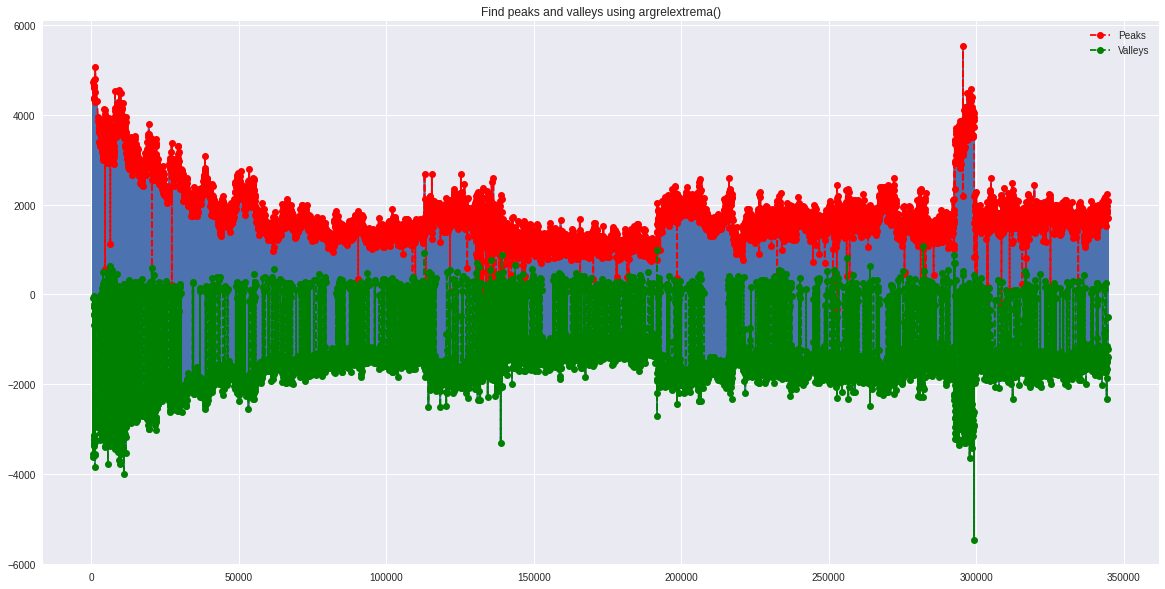

In [731]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

#L1, L2 = 5000, 11000#len(bwrPPG1)
#L1, L2 = 105500, 107000#len(bwrPPG1)
L1, L2 = 0, len(bwrPPG1)
# find peak max
peak_idxs1 = signal.argrelextrema(bwrPPG1, np.greater,order=10)#5 18
peak_idxs1 = peak_idxs1[0]
peak_idxs1 = [i  for i in peak_idxs1 if (i >=L1 and i <=L2)]

#find peak min
valley_idxs1 = signal.argrelextrema(bwrPPG1, np.less,order=5) #1
valley_idxs1 = valley_idxs1[0]
valley_idxs1 = [i  for i in valley_idxs1 if (i >=L1 and i <=L2)]
#plot main graph
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(bwrPPG1[L1:L2])
# plot peaks
peak_x1 = [i - L1 for i in peak_idxs1]
peak_y1 =  bwrPPG1[peak_idxs1]
ax.plot(peak_x1, peak_y1, marker='o', linestyle='dashed', color='r', label='Peaks')
# plot valleys
valley_x1 = [i - L1 for i in valley_idxs1]
valley_y1 =  bwrPPG1[valley_idxs1]
ax.plot(valley_x1, valley_y1, marker='o', linestyle='dashed', color='g', label='Valleys')

# Save graph to file.
plt.title('Find peaks and valleys using argrelextrema()')
plt.legend(loc='best')
#plt.savefig('argrelextrema.png')

##STOP HERE TO NEXT STEP

In [505]:
new_peakidx1 = filter_peak(bwrPPG1, peak_idxs1)

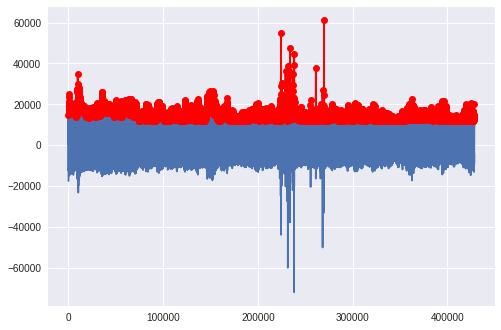

In [506]:
plt.plot(bwrPPG1)
plt.plot(new_peakidx1, bwrPPG1[new_peakidx1], marker='o',color='r')

In [533]:
signal = bwrPPG1[L1:L2]
index = [i - L1 for i in peak_idxs1]
new_peakidx1 = filter_peak(signal, index)

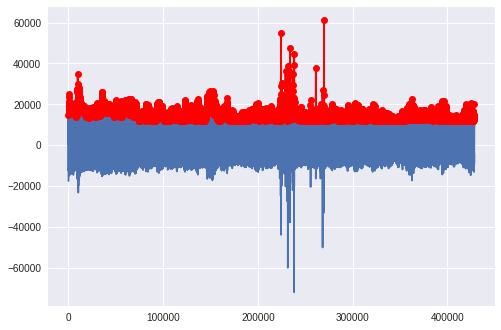

In [534]:
plt.plot(signal)
plt.plot(new_peakidx1, signal[new_peakidx1], marker='o',color='r')

In [ ]:
len(new_peakidx1)

232

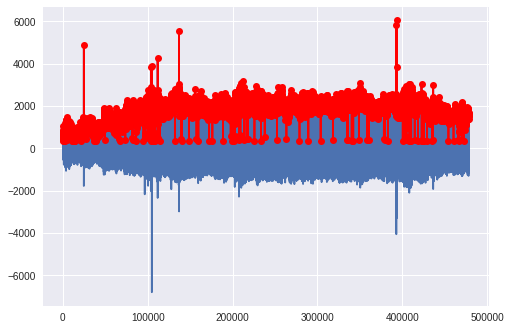

In [413]:
plt.plot(bwrPPG1)
index = [i + L1 for i in new_peakidx1]
plt.plot(index, bwrPPG1[index], marker='o',color='r')

In [ ]:
plt.plot(signal)
plt.plot(new_peakidx1, signal[new_peakidx1], marker='o',color='r')

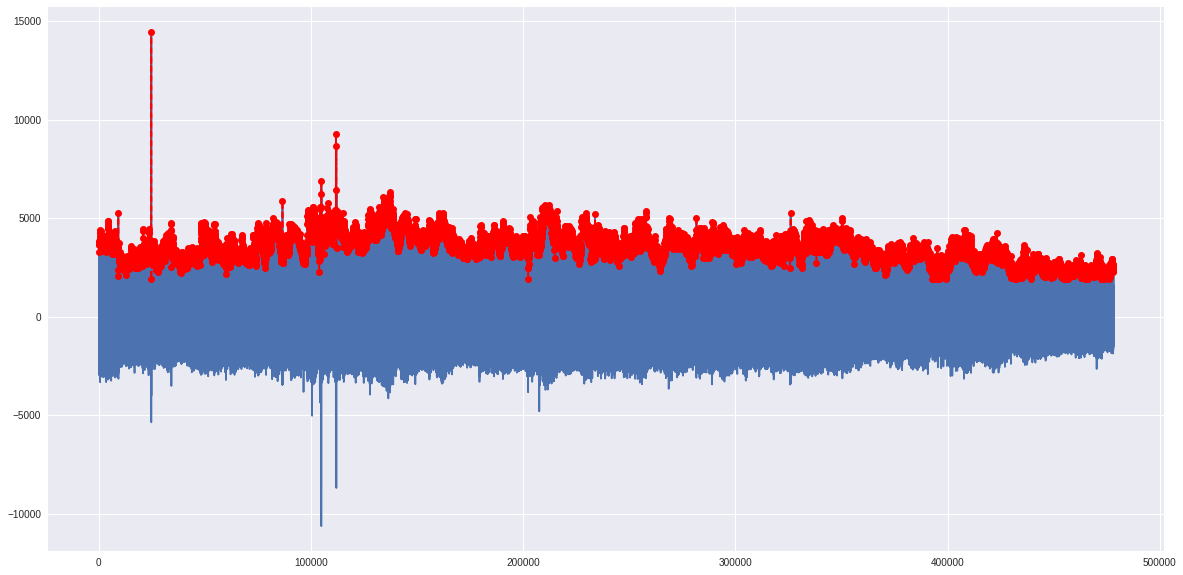

In [452]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(bwrPPG1[L1:L2])
# plot peaks
peak_x2 = [i - L1 for i in new_peakidx1]
peak_y2 =  bwrPPG1[new_peakidx1]
ax.plot(peak_x2, peak_y2, marker='o', linestyle='dashed', color='r', label='Peaks')

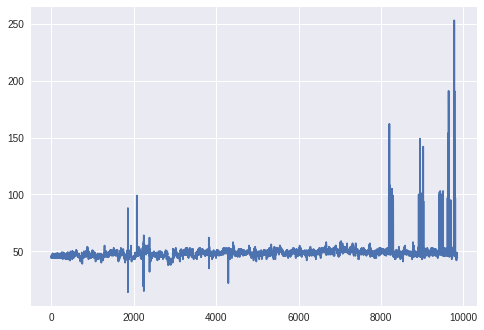

In [453]:
plt.plot(np.diff(peak_x2))

### Algorithm selecting peaks
* Step 1: Make a window to check the threshold to cut max peaks and sub peaks
** Check quantile of data windows 
  threshold $\theta$ = 0.5; this seperate almost max peaks and min peaks
** Need to check some wrong peaks in upset make a new threshold base on mean
* Step 2: Search with window for full signal


In [374]:
def filter_peak(signal, idx):
#signal = peak_y1
  #len(signal)
  s = signal[idx]

  high = .50
## get the firsth value threshold for 50%
  quant_df = pd.DataFrame(signal[idx]).quantile([high])
  
  lowset = s[s < quant_df[0][high]]
  #print(np.mean(lowset))
  #print(lowset)
  #new_signal = signal[s > np.mean(lowset)]
  new_idx = [i for i in idx if signal[i] > np.mean(lowset)]
  return new_idx




In [ ]:
def select_peaks(signal, idx, L, L1): #idx absoluted positions
  #signal (np array) signal 
  # idx: index of signal peaks
  # Length L
  if len(signal) < L:
    sub_idx = [i-L1 for i in idx]
    idx1 = filter_peak(signal, sub_idx)
    new_idx = [i + L1 for i in idx1]
    
  else:
    #print(len(signal))
    sub_L = [i for i in range(0,len(signal), L)]
    print(sub_L)
    new_idx = [] 
    for l in sub_L[:-1]:
      #print(l)
      #set N subset of signal with each subset has length L
      s=signal[l:l+L]
      #print(len(s))
      #find index of peak in this subset s
      # shifting by (l + L1)
      sub_idx = [i - l - L1 for i in idx if i < l+L+L1 and i >=l + L1] # Not optimized
      #print(sub_idx)
      idx1 = filter_peak(s, sub_idx)
      # back to (l + L1)
      sub_idx = [i + l + L1 for i in idx1] # Not optimized
      new_idx.extend(sub_idx)
      #print(sub_idx)
    # include the last subset
    l = sub_L[-1]
    s=signal[l:]
    # shifting by (l + L1)
    sub_idx = [i-l-L1 for i in idx if i >=l+L1]
    idx1 = filter_peak(s, sub_idx)
    # back to (l + L1)
    sub_idx = [i + l + L1 for i in idx1] # Not optimized
    #print(sub_idx)
    new_idx.extend(sub_idx)
  return new_idx  
  


### Join peaks in to new set
Check a point i distance to (i - 1) and (i + 1) is small than << np.median(Peaks set) and removed

In [ ]:
def remove_peaks(peakset):
  M = np.median(np.diff(peakset))
  new_set=[peakset[0]]
  
  for i in range(1,len(peakset)): # explore from i =1 to the previous of last element
    if (peakset[i]-new_set[-1] > M*4/5) :#and (peakset[i]-new_set[-1] < M*3/2)
      new_set.append(peakset[i])
    # skip this point
    #  continue
    #else:
      
  return new_set


## CONTINOUS HERE

### Filtering peaks

$1^{st}$ Filtering

In [732]:
new_peakidx1 = select_peaks(bwrPPG1[L1:L2], peak_idxs1,L=2000, L1=L1)

[0, 2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000, 18000, 20000, 22000, 24000, 26000, 28000, 30000, 32000, 34000, 36000, 38000, 40000, 42000, 44000, 46000, 48000, 50000, 52000, 54000, 56000, 58000, 60000, 62000, 64000, 66000, 68000, 70000, 72000, 74000, 76000, 78000, 80000, 82000, 84000, 86000, 88000, 90000, 92000, 94000, 96000, 98000, 100000, 102000, 104000, 106000, 108000, 110000, 112000, 114000, 116000, 118000, 120000, 122000, 124000, 126000, 128000, 130000, 132000, 134000, 136000, 138000, 140000, 142000, 144000, 146000, 148000, 150000, 152000, 154000, 156000, 158000, 160000, 162000, 164000, 166000, 168000, 170000, 172000, 174000, 176000, 178000, 180000, 182000, 184000, 186000, 188000, 190000, 192000, 194000, 196000, 198000, 200000, 202000, 204000, 206000, 208000, 210000, 212000, 214000, 216000, 218000, 220000, 222000, 224000, 226000, 228000, 230000, 232000, 234000, 236000, 238000, 240000, 242000, 244000, 246000, 248000, 250000, 252000, 254000, 256000, 258000, 260000, 262000, 2

In [415]:
#new_peakidx1 = filter_peak(bwrPPG1, new_peakidx1)

$2^{nd}$ Filtering

In [512]:
new_peakidx1 = select_peaks(bwrPPG1[L1:L2], new_peakidx1,L=2000, L1=L1)

[0, 2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000, 18000, 20000, 22000, 24000, 26000, 28000, 30000, 32000, 34000, 36000, 38000, 40000, 42000, 44000, 46000, 48000, 50000, 52000, 54000, 56000, 58000, 60000, 62000, 64000, 66000, 68000, 70000, 72000, 74000, 76000, 78000, 80000, 82000, 84000, 86000, 88000, 90000, 92000, 94000, 96000, 98000, 100000, 102000, 104000, 106000, 108000, 110000, 112000, 114000, 116000, 118000, 120000, 122000, 124000, 126000, 128000, 130000, 132000, 134000, 136000, 138000, 140000, 142000, 144000, 146000, 148000, 150000, 152000, 154000, 156000, 158000, 160000, 162000, 164000, 166000, 168000, 170000, 172000, 174000, 176000, 178000, 180000, 182000, 184000, 186000, 188000, 190000, 192000, 194000, 196000, 198000, 200000, 202000, 204000, 206000, 208000, 210000, 212000, 214000, 216000, 218000, 220000, 222000, 224000, 226000, 228000, 230000, 232000, 234000, 236000, 238000, 240000, 242000, 244000, 246000, 248000, 250000, 252000, 254000, 256000, 258000, 260000, 262000, 2

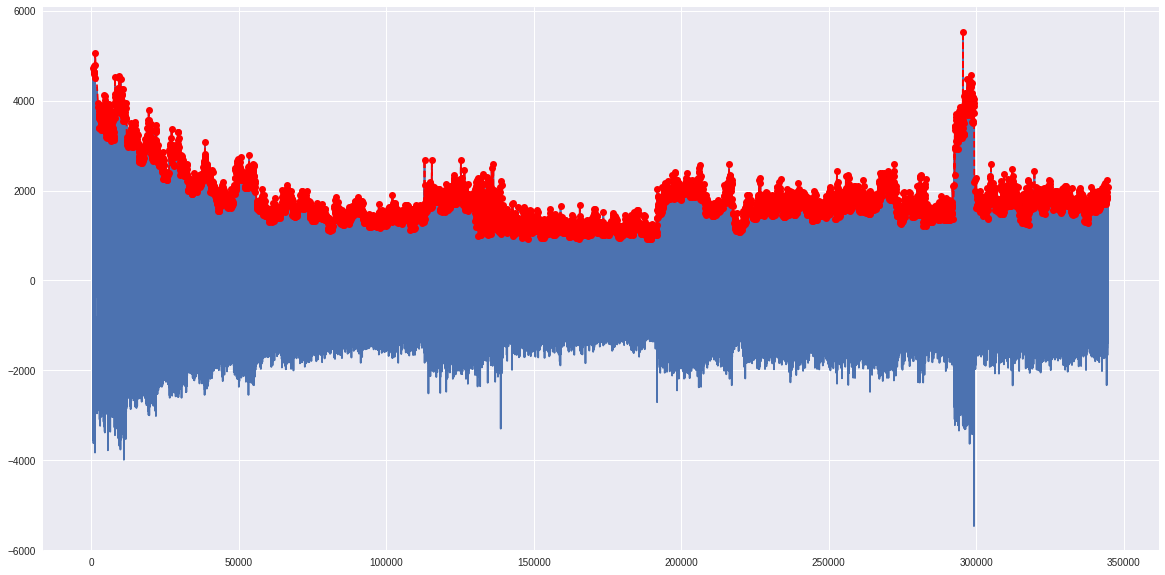

In [733]:
fig, ax = plt.subplots(figsize=(20,10))
#L1, L2 = 10000, 15000
ax.plot(bwrPPG1[L1:L2])
# plot peaks
peak_x2 = [i - L1 for i in new_peakidx1]
peak_y2 =  bwrPPG1[new_peakidx1]
ax.plot(peak_x2, peak_y2, marker='o', linestyle='dashed', color='r', label='Peaks')

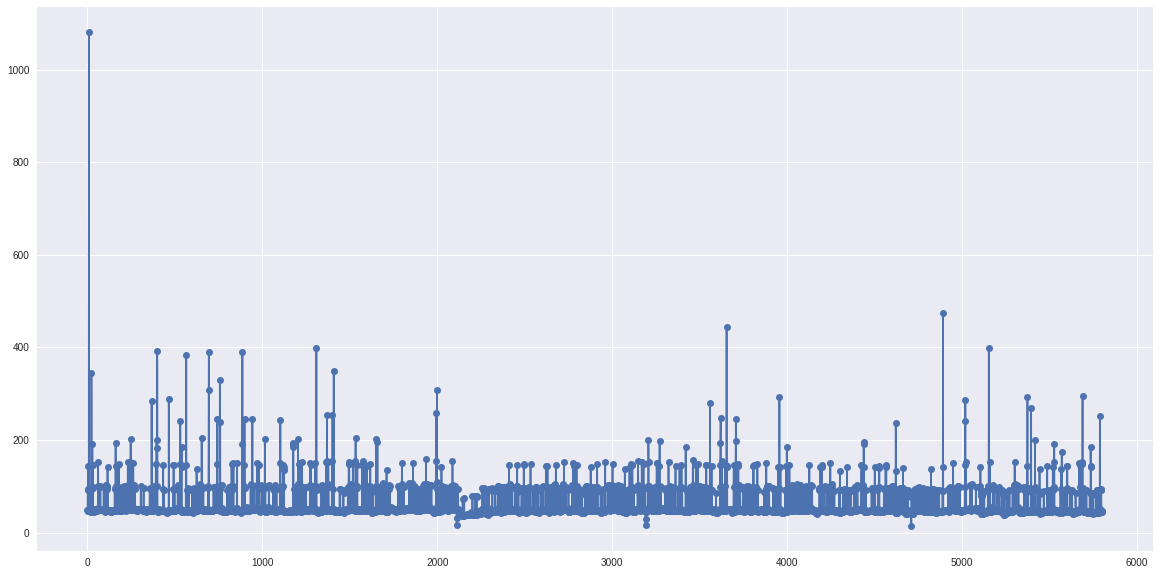

In [734]:
R_PTT = pd.DataFrame(np.diff(peak_x2))
#R_PTT = pd.DataFrame(np.array(peak_idxs1[0:-1]) )
#R_PTT = pd.DataFrame(np.gradient(valley_idxs1))
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(R_PTT,marker='o')

In [735]:
peak_x3 = remove_peaks(peak_x2)

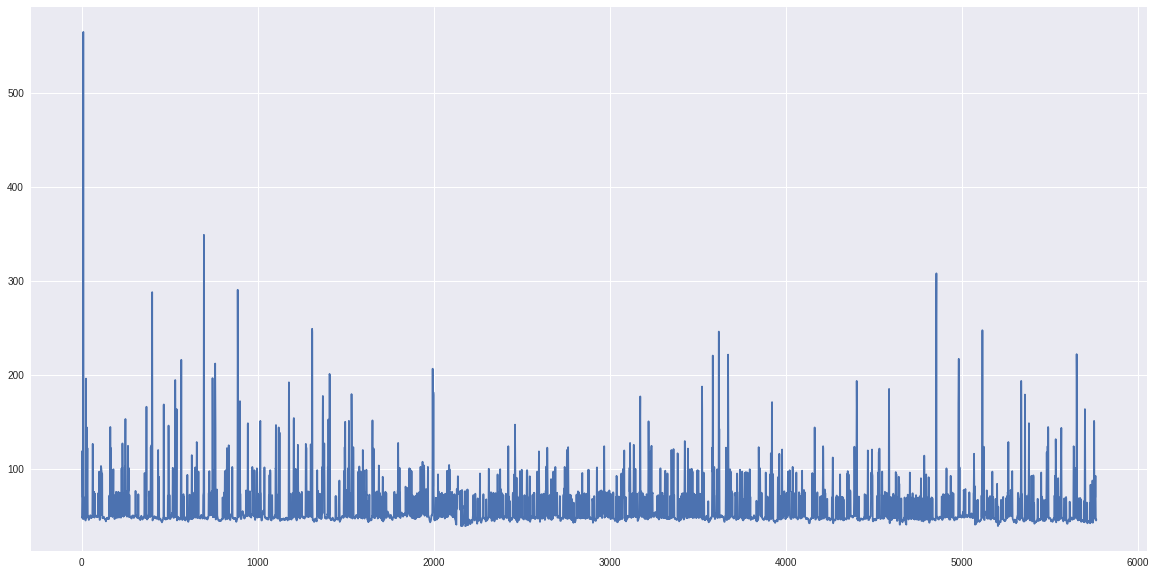

In [736]:
R_PTT = pd.DataFrame(np.gradient(peak_x3))
#R_PTT = pd.DataFrame(np.array(peak_idxs1[0:-1]) )
#R_PTT = pd.DataFrame(np.gradient(valley_idxs1))
fig, ax = plt.subplots(figsize=(20,10))
#ax.plot(R_PTT,marker='o')
ax.plot(R_PTT)

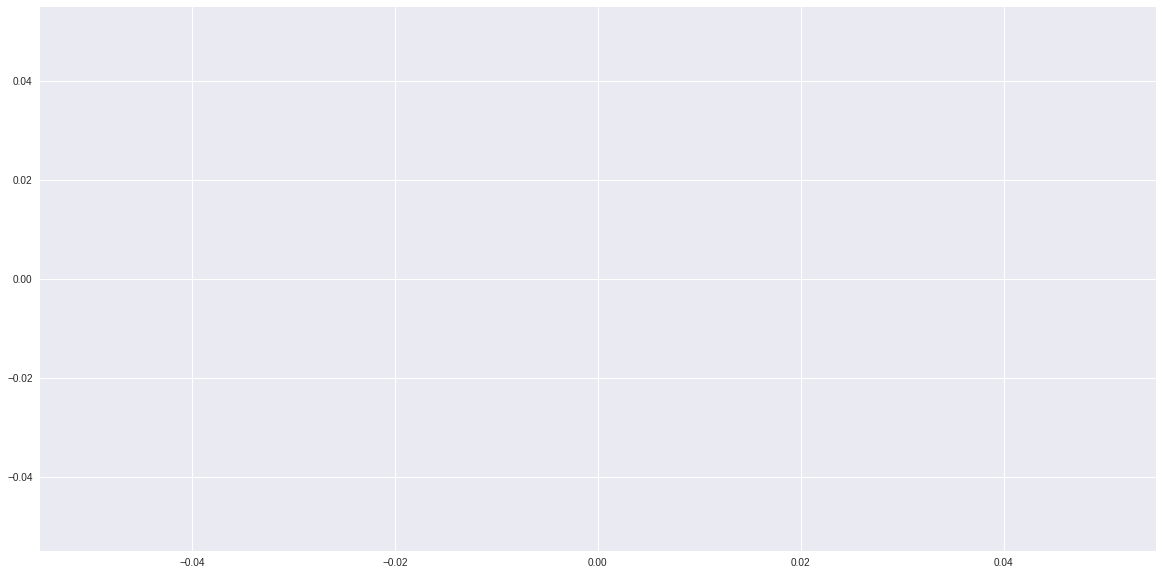

In [737]:
a , b = 7000, 8000
R_PTT = pd.DataFrame(np.diff(peak_x3[a:b]))
#R_PTT = pd.DataFrame(np.array(peak_idxs1[0:-1]) )
#R_PTT = pd.DataFrame(np.gradient(valley_idxs1))
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(R_PTT,marker='o')

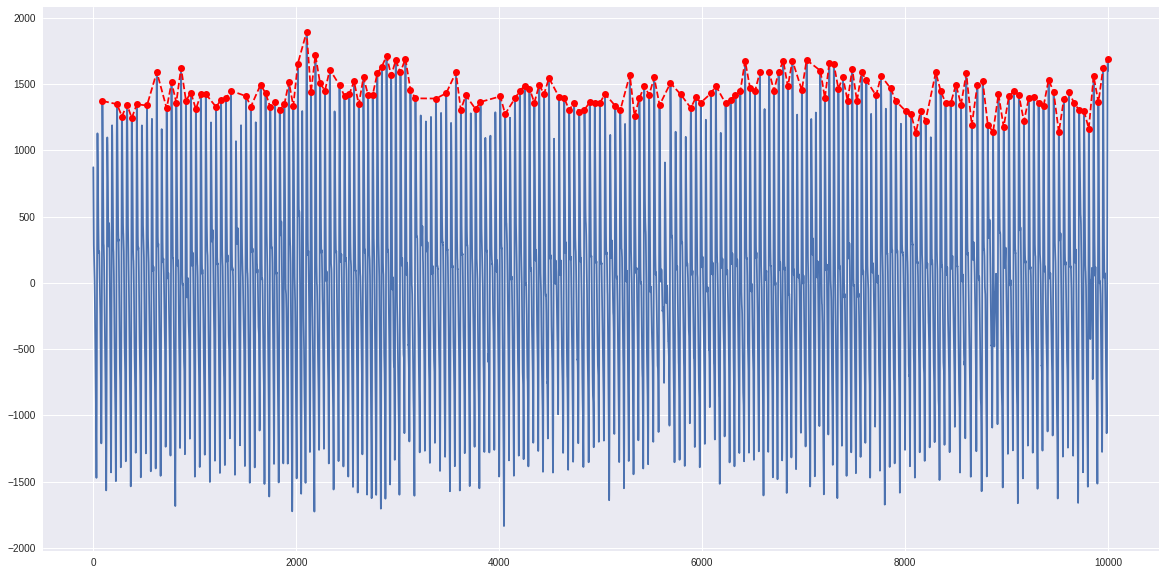

In [738]:
fig, ax = plt.subplots(figsize=(20,10))
L1, L2 = 100000, 110000
ax.plot(bwrPPG1[L1:L2])
# plot peaks
peak_x3 = remove_peaks(peak_x2)
x3 = [i for i in peak_x3 if i<L2 and i>=L1]
y3 = bwrPPG1[x3]
x3rel = np.array(x3) - L1
ax.plot(x3rel, y3, marker='o', linestyle='dashed', color='r', label='Peaks')

In [739]:
from scipy.signal import savgol_filter

#filter_PPG1 = savgol_filter(filter_PPG, window_length = 211, polyorder =5)
filterPTT = savgol_filter(np.diff(peak_x3), window_length = 141, polyorder =0)
filterPTT2 = savgol_filter(np.diff(peak_x3), window_length = 71, polyorder =0)

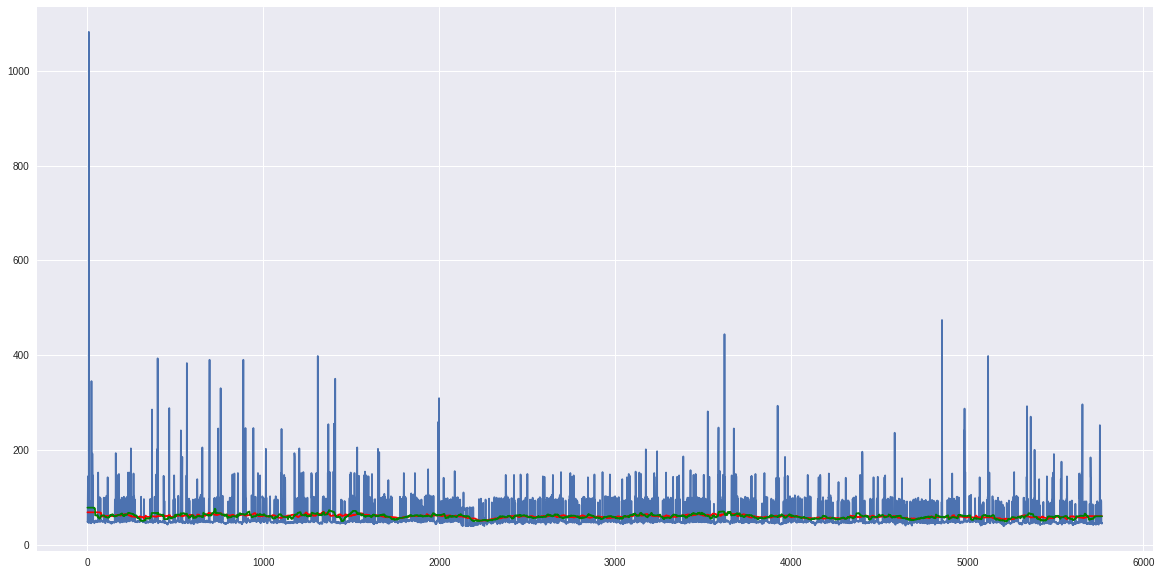

In [740]:
R_PTT = pd.DataFrame(np.diff(peak_x3))
#R_PTT = pd.DataFrame(np.array(peak_idxs1[0:-1]) )
#R_PTT = pd.DataFrame(np.gradient(valley_idxs1))
fig, ax = plt.subplots(figsize=(20,10))
#ax.plot(R_PTT,marker='o')
ax.plot(R_PTT)
ax.plot(filterPTT, "r-")
ax.plot(filterPTT2, "g-")

### Take mean with bin 5-100

In [741]:
meanPTT= R_PTT.rolling(421,win_type='blackman' ).mean()
meanPTT= R_PTT.rolling(421 ).median()

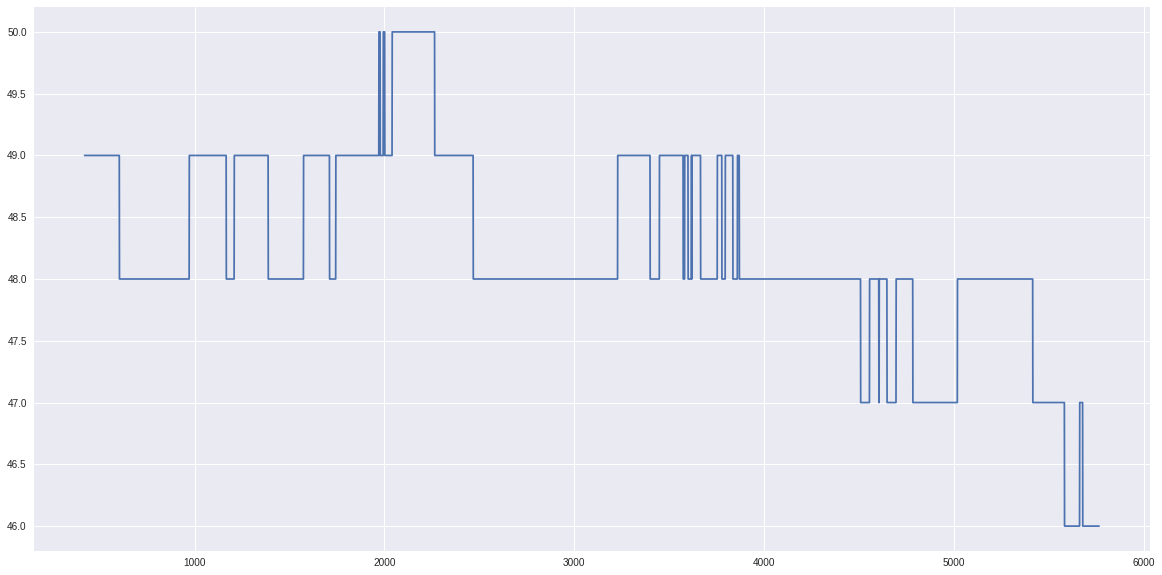

In [742]:
fig, ax = plt.subplots(figsize=(20,10))
#ax.plot(R_PTT,marker='o')
ax.plot(meanPTT)

In [320]:
len(peak_x2), len(peak_x3)

(11669, 9927)

### Check amplitude of Peak to remove points


In [ ]:
Amp = 250
peak_idxs2 = [p for p in peak_idxs1 if bwrPPG1[p] > Amp ]

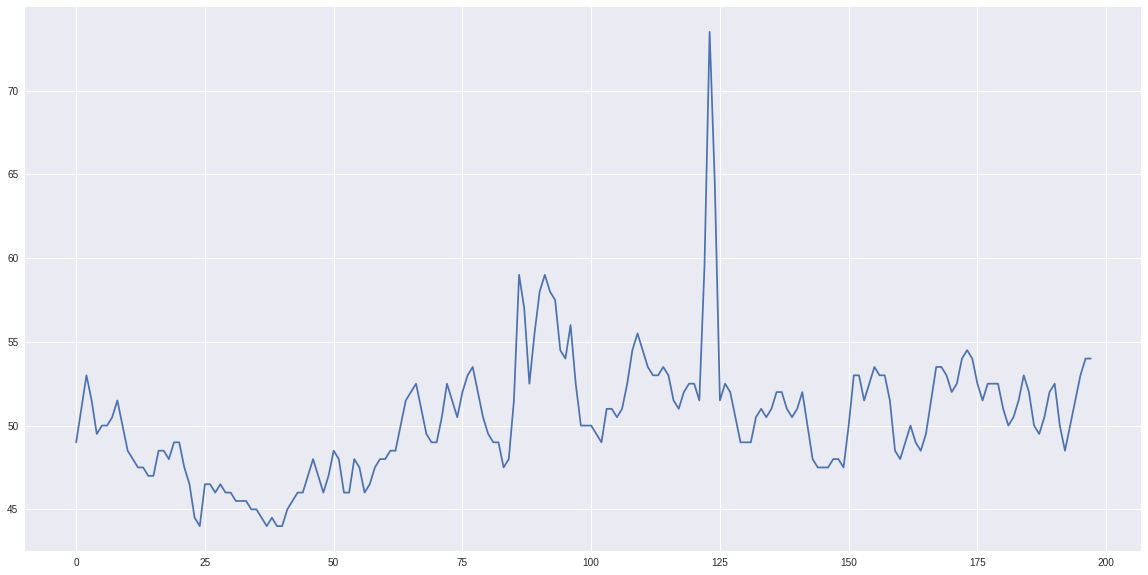

In [ ]:
R_PTT2 = pd.DataFrame(np.gradient(x3))
#R_PTT = pd.DataFrame(np.array(peak_idxs1[0:-1]) )
#R_PTT = pd.DataFrame(np.gradient(valley_idxs1))
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(R_PTT2)

In [ ]:
len(peak_idxs2), np.median(R_PTT2)

In [ ]:
np.median(R_PTT), np.mean(R_PTT)

(50.5, 0    44.818182
 dtype: float64)

In [ ]:
def filter_peaks2(peakset, signal):
#signal = R_PTT
#peakset = peak_idxs1

  M = np.median(signal)
  i = 0
  L = len(peakset)
  new_peak=[]
  while (i<L-1):
    j=1
  #l = (peak_idxs1[i+j]-peak_idxs1[i])
    while ((peakset[i+j]-peakset[i]) <2/3*M):# and (peak_idxs1[i+j]-peak_idxs1[i]) < 4/3*M):
      j+=1
      if j>=L-1:
        break
  #print(j)
    new_peak.append(peakset[i])
     
    i+=j
  return new_peak

new_peakidx1 = filter_peaks2(peak_idxs2, R_PTT2)

In [ ]:
2/3*M, 4/3*M,peak_idxs1[i+j]-peak_idxs1[i]

(35.0, 70.0, 150)

In [ ]:
i = 0; j=1
((peak_idxs1[i+j]-peak_idxs1[i]  > 2/3*M) and (peak_idxs1[i+j]-peak_idxs1[i] < 4/3*M))

True

In [ ]:
i = 0; j=2
((peak_idxs1[i+j]-peak_idxs1[i]  < 2/3*M))#or (peak_idxs1[i+j]-peak_idxs1[i] > 4/3*M))

False

In [ ]:
 (peak_idxs1[i+j]-peak_idxs1[i]  < 2/3*M), (peak_idxs1[i+j]-peak_idxs1[i] > 4/3*M) 

(False, True)

In [ ]:
len(new_peakidx1), len(peak_idxs1)

(9925, 10201)

In [ ]:
bwrPPG1[7]

438.58617653592955

In [ ]:
new_peakidx1

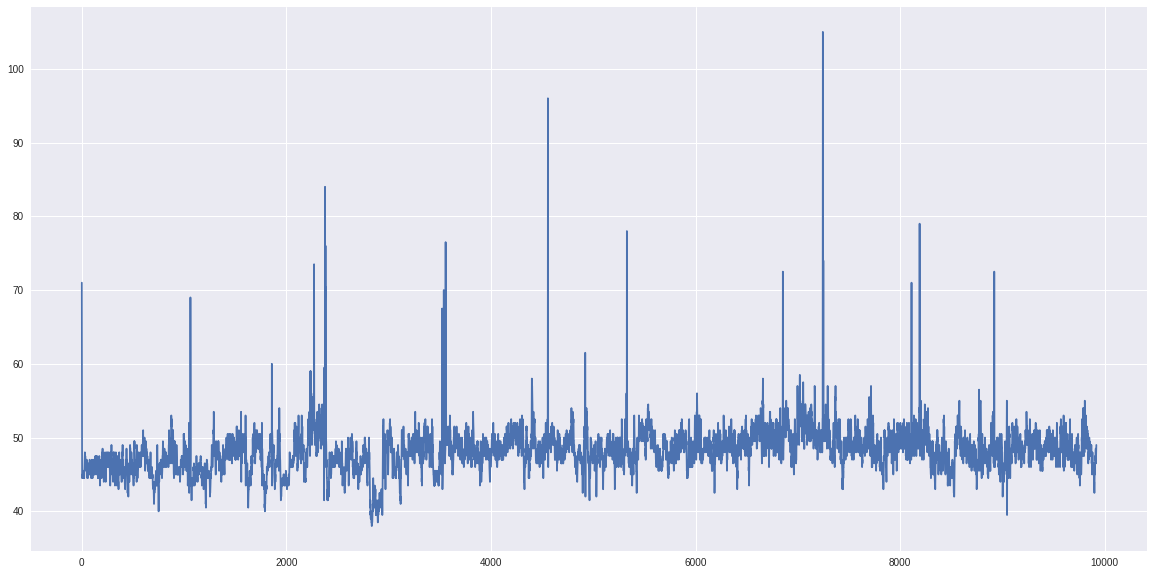

In [ ]:
R_PTT1 = pd.DataFrame(np.gradient(new_peakidx1))
#R_PTT = pd.DataFrame(np.array(peak_idxs1[0:-1]) )
#R_PTT = pd.DataFrame(np.gradient(valley_idxs1))
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(R_PTT1)

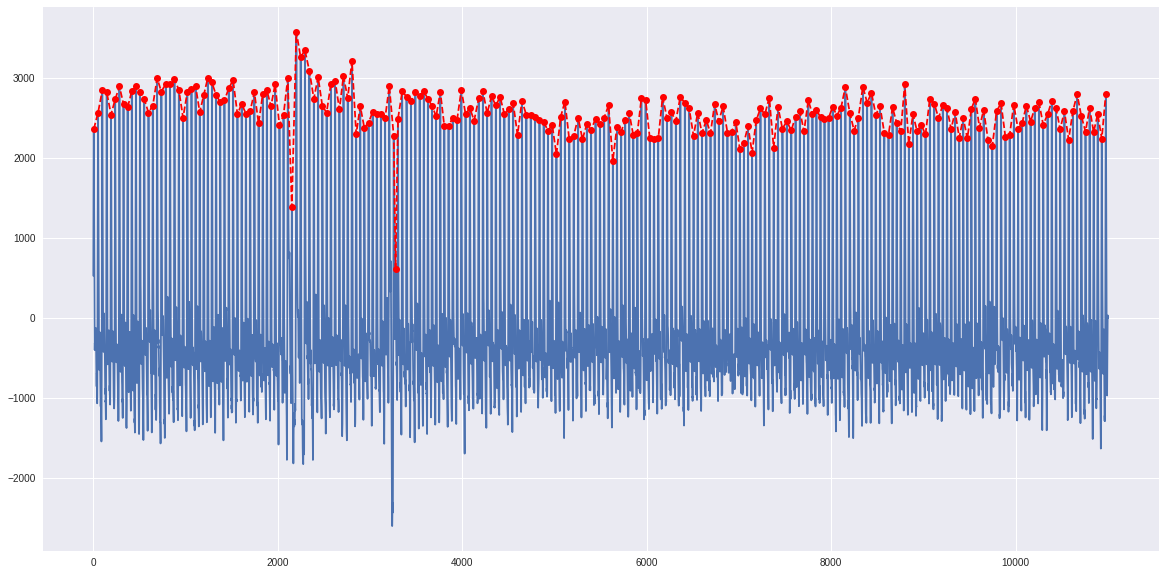

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(bwrPPG1[L1:L2])
# plot peaks
peak_x2 = [i - L1 for i in new_peakidx1]
peak_y2 =  bwrPPG1[new_peakidx1]
ax.plot(peak_x2, peak_y2, marker='o', linestyle='dashed', color='r', label='Peaks')

(array([25., 30., 35., 40., 45., 50., 55., 60., 65.]),
 <a list of 9 Text major ticklabel objects>)

<Figure size 720x720 with 0 Axes>

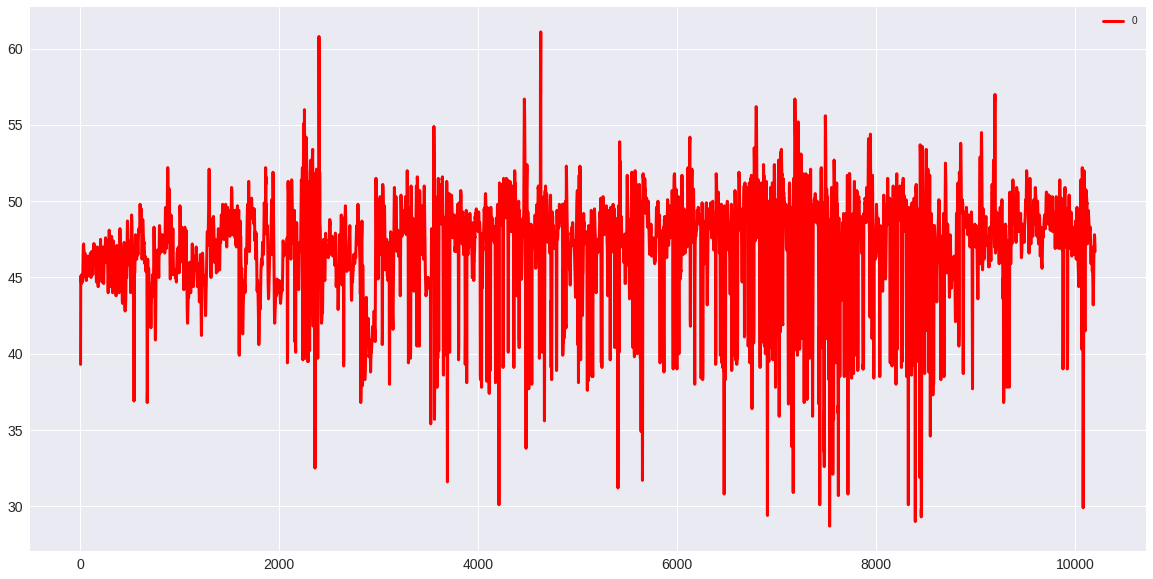

In [ ]:
plt.figure(1, figsize=(10,10))
# colors for the line plot
colors = ['green', 'red', 'purple']

#dzMA = R_PTT.rolling(2000, win_type='blackman' ).mean()### 'blackman','bohman'win_type='None'
dzMA = R_PTT.rolling(5 ).mean()### 'blackman','bohman'win_type='None'
### create a combine dataframe
#df = pd.DataFrame(dzMA,idx, ignore_index=True)
#df['avg'] = ppgMVA
#plt.plot(ppg525, "g-", label='PPG at 525nm')
#plt.plot(ppgMVA, "r-", label='Moving Average of PPG at 525nm')
dzMA.plot(color=colors[1], linewidth=3, figsize=(20,10))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [ ]:
len(R_PTT), len(dzMA)

(25014, 25014)

In [ ]:
dzMA

In [ ]:
R_PTT.describe()

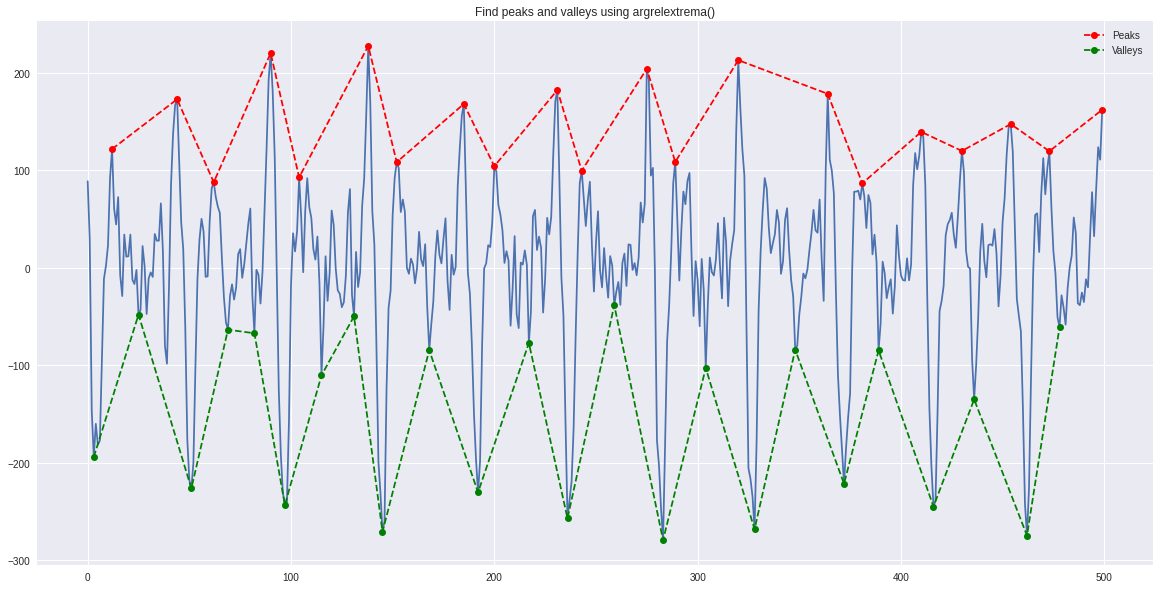

In [ ]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

L1, L2 = 7000, 7500#len(bwrPPG1)
# find peak max
d2_bwrPPG1 = np.gradient(np.gradient(bwrPPG1))
peak_idxs1 = signal.argrelextrema(d2_bwrPPG1, np.greater,order=10)
peak_idxs1 = peak_idxs1[0]
peak_idxs1 = [i  for i in peak_idxs1 if (i >=L1 and i <=L2)]

#find peak min
valley_idxs1 = signal.argrelextrema(d2_bwrPPG1, np.less,order=10)
valley_idxs1 = valley_idxs1[0]
valley_idxs1 = [i  for i in valley_idxs1 if (i >=L1 and i <=L2)]
#plot main graph
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(d2_bwrPPG1[L1:L2])
# plot peaks
peak_x1 = [i - L1 for i in peak_idxs1]
peak_y1 =  d2_bwrPPG1[peak_idxs1]
ax.plot(peak_x1, peak_y1, marker='o', linestyle='dashed', color='r', label='Peaks')
# plot valleys
valley_x1 = [i - L1 for i in valley_idxs1]
valley_y1 =  d2_bwrPPG1[valley_idxs1]
ax.plot(valley_x1, valley_y1, marker='o', linestyle='dashed', color='g', label='Valleys')

# Save graph to file.
plt.title('Find peaks and valleys using argrelextrema()')
plt.legend(loc='best')
#plt.savefig('argrelextrema.png')

###Reading Glucose

In [488]:
from pandas import read_csv
file_path = file_path = 'drive/My Drive/Dataset/GlucoseLong02_02April.csv'
#file_path = file_path = 'drive/My Drive/Dataset/GlucoseLong02_12Mar.csv'
dataset = read_csv(file_path,
                   
                   parse_dates=['Timestamp (YYYY-MM-DDThh:mm:ss)'],
                   index_col=['Timestamp (YYYY-MM-DDThh:mm:ss)'],
                   skiprows= [i for i in range(1,11)],
                   na_values= ['nan'])

 ### Find index in time series

In [486]:
import numpy
def find_index(dataset, time):
   s = [index for index in range(len(dataset.index.values)) if dataset.index.values[index] == numpy.datetime64(time)]
   return s[0]

In [615]:
#02April: ['2021-04-02T15:14:40','2021-04-02T17:19:40']
#01April: ['2021-04-01T14:04:41','2021-04-01T16:09:40']
#31Marchl: ['2021-04-01T14:04:41','2021-04-01T16:09:40']
x_start = find_index(dataset, '2021-03-31T14:54:40')  
x_stop = find_index(dataset, '2021-03-31T17:04:39') 

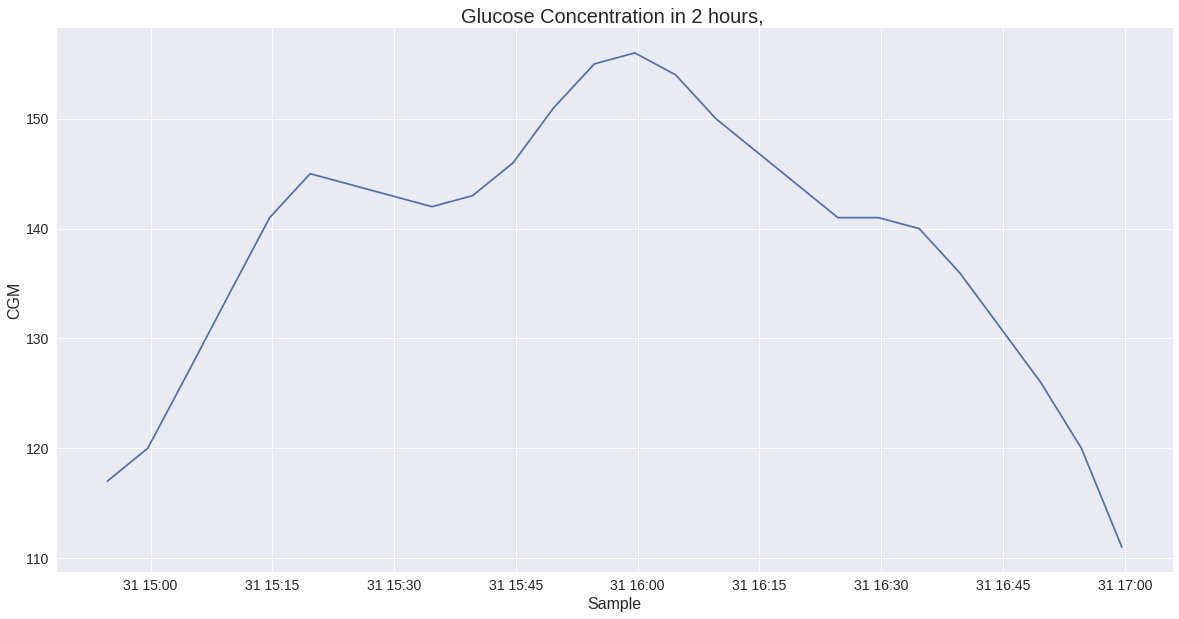

In [616]:
df_glu = dataset['Glucose Value (mg/dL)'][x_start:x_stop]
plt.figure(1, figsize=(20,10))
plt.plot(df_glu)
# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


# title and labels
plt.title('Glucose Concentration in 2 hours, ', fontsize=20)
plt.xlabel('Sample', fontsize=16)
plt.ylabel('CGM', fontsize=16)
plt.show()